<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spatial attention



### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model with Attention Layers

In [20]:
img_size_div4 = 45 # Image size

class AttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(AttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7,padding=3)  # Generates a single channel score map

    def forward(self, x):
        attention_weights = torch.sigmoid(self.conv(x))  # Sigmoid to get values in range [0, 1]
        return attention_weights, x * attention_weights

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability of dropping units
        self.fc1 = nn.Linear(16 * img_size_div4 * img_size_div4, 128)  # Reduced from 256 to 128
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 classes
        self.attn1 = AttentionLayer(8) # First attention layer
        self.attn2 = AttentionLayer(16) # Second attention layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # First convolutional layer with ReLU and pooling
        attn1_weights, x = self.attn1(x) # First attention layer
        x = self.pool(torch.relu(self.conv2(x)))  # Second convolutional layer with ReLU and pooling
        attn2_weights, x = self.attn2(x)  # Second attention layer
        x = self.dropout(x)  # Apply dropout
        x = x.view(-1, 16 * img_size_div4 * img_size_div4)  # Flatten the output for the fully connected layer
        x = torch.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.dropout(x) # Apply dropout to the fully connected layer output
        x = self.fc2(x)  # Output layer
        return x, attn1_weights, attn2_weights

### Load and Edit Data

In [3]:
img_size = img_size_div4 * 4 # Define image size

train_transform = transforms.Compose([ # Define transformations for training
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=4),   # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([ # Define transformations for testing (no augmentation)
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 20
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lr = 0.0006 # Learning rate
num_epochs = 20 # Number of epochs for training

model = CNN().to(device) # Initialise a model
criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output,_,_ = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Using device: cuda
Epoch 1/20, Loss: 1.1296, Accuracy: 0.3755
Epoch 2/20, Loss: 1.0811, Accuracy: 0.4276
Epoch 3/20, Loss: 1.0827, Accuracy: 0.3966
Epoch 4/20, Loss: 1.0591, Accuracy: 0.4205
Epoch 5/20, Loss: 1.0548, Accuracy: 0.4543
Epoch 6/20, Loss: 0.9978, Accuracy: 0.4979
Epoch 7/20, Loss: 0.9911, Accuracy: 0.5345
Epoch 8/20, Loss: 0.9315, Accuracy: 0.5752
Epoch 9/20, Loss: 0.8915, Accuracy: 0.5921
Epoch 10/20, Loss: 0.8199, Accuracy: 0.6259
Epoch 11/20, Loss: 0.7483, Accuracy: 0.6695
Epoch 12/20, Loss: 0.7137, Accuracy: 0.7117
Epoch 13/20, Loss: 0.6786, Accuracy: 0.6892
Epoch 14/20, Loss: 0.5914, Accuracy: 0.7496
Epoch 15/20, Loss: 0.5882, Accuracy: 0.7609
Epoch 16/20, Loss: 0.5367, Accuracy: 0.7834
Epoch 17/20, Loss: 0.5001, Accuracy: 0.8017
Epoch 18/20, Loss: 0.4520, Accuracy: 0.8186
Epoch 19/20, Loss: 0.4193, Accuracy: 0.8383
Epoch 20/20, Loss: 0.4052, Accuracy: 0.8523


### Testing the Model

In [22]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output,_,_ = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6228


### Code for Visualising an Image & Attention Layers

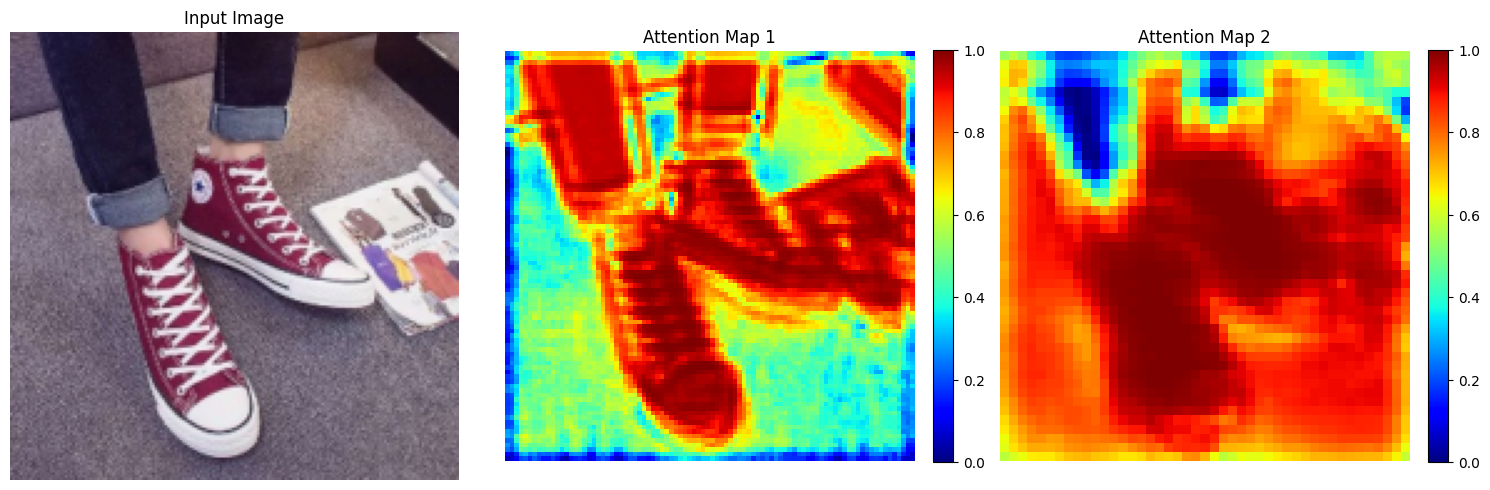

In [38]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return img * std + mean

def visualize_attention(model, loader):
    image, label = random.choice(list(loader))
    image = image[12].unsqueeze(0)  # Single image, keep batch dimension
    label = label[12].item()

    original_image = denormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    original_image = original_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    original_image = np.clip(original_image, 0, 1)

    model.eval() # Pass the image through the model
    with torch.no_grad():
        image = image.cpu()
        output, attn1_weights, attn2_weights = model(image)

    attn1_map = attn1_weights.squeeze().cpu().detach().numpy()  # Convert attention weights to the shape of the feature map
    attn2_map = attn2_weights.squeeze().cpu().detach().numpy()

    attn1_map = (attn1_map - attn1_map.min()) / (attn1_map.max() - attn1_map.min())  # Normalize the attention maps to [0, 1] for visualization
    attn2_map = (attn2_map - attn2_map.min()) / (attn2_map.max() - attn2_map.min())

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image) # Plot the original image
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    im1 = axes[1].imshow(attn1_map, cmap='jet') # Plot attention map 1
    axes[1].set_title('Attention Map 1')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(attn2_map, cmap='jet') # Plot attention map 2
    axes[2].set_title('Attention Map 2')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

model = model.to('cpu')
visualize_attention(model, test_loader) # Visualize the attention maps for this image